## This notebook shows how to use Orchestrator APIs for user experiments

In [1]:
import os
from fabrictestbed.slice_manager import SliceManager, Status, SliceState
import json

In [10]:
ssh_key_file_priv=os.environ['HOME']+"/.ssh/id_rsa"
ssh_key_file_pub=os.environ['HOME']+"/.ssh/id_rsa.pub"

ssh_key_pub = None
with open (ssh_key_file_pub, "r") as myfile:
    ssh_key_pub=myfile.read()
    ssh_key_pub=ssh_key_pub.strip()

In [11]:
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
print(f"FABRIC Credential Manager   : {credmgr_host}")

orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"FABRIC Orchestrator         : {orchestrator_host}")

FABRIC Credential Manager   : beta-2.fabric-testbed.net
FABRIC Orchestrator         : beta-7.fabric-testbed.net


## Create Slice Manager Object
Users can request tokens with different Project and Scopes by altering `project_name` and `scope` parameters in the refresh call below.

In [4]:
slice_manager = SliceManager(oc_host=orchestrator_host, 
                             cm_host=credmgr_host ,
                             project_name='all', 
                             scope='all')

# Initialize the slice manager
slice_manager.initialize()

### Orchestrator API example to query for available resources

In [5]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

Status: Status.OK
Toplogy: UKY: { cpu: 6/6 , core: 186/192 , ram: 1,488/1,536 G, disk: 9,300/9,600 G, unit: 3/3 }
	Components:
		NVME-P4510:  NVME P4510 { disk: 8,000/10,000 G, unit: 8/10 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 381/381 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 1/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
	Site Interfaces:
		UKY_RENC: TrunkPort { bw: 100/100 Gbps}
		UKY_LBNL: TrunkPort { bw: 100/100 Gbps}
LBNL: { cpu: 6/6 , core: 188/192 , ram: 1,504/1,536 G, disk: 9,400/9,600 G, unit: 3/3 }
	Components:
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 381/381 }
		NVME-P4510:  NVME P4510 { disk: 10,000/10,000 G, unit: 10/10 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 1/2 }
	Site Inte

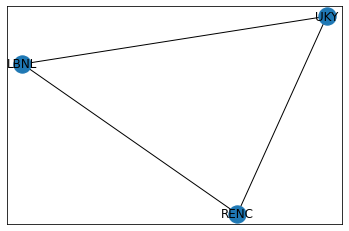

In [6]:
if status == Status.OK:
    advertised_topology.draw()

## Create Slice
In Release 1.0, user is expected to create tagged interface and assign the IP addresses manually. Please use the example comands indicated below:

## Configure Slice Parameters



In [7]:
slice_name = 'MySlice'
site1 = 'RENC'
site2 = 'LBNL'
node1_name = 'Node1'
node2_name = 'Node2'
node3_name = 'Node3'
network_service_name='site2site1'
nic1_name = 'node1-nic1'
nic2_name = 'node2-nic1'
nic3_name = 'node3-nic1'
image = 'default_centos_8'
image_type = 'qcow2'
cores = 2
ram = 16
disk = 100

In [8]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType
# Create topology
t = ExperimentTopology()

# Add node
n1 = t.add_node(name=node1_name, site=site1)

# Set capacities
cap = Capacities()
cap.set_fields(core=cores, ram=ram, disk=disk)

# Set Properties
n1.set_properties(capacities=cap, image_type=image_type, image_ref=image)

# Add node
n2 = t.add_node(name=node2_name, site=site1)

# Set properties
n2.set_properties(capacities=cap, image_type=image_type, image_ref=image)

# Add node
n3 = t.add_node(name=node3_name, site=site2)

# Set properties
n3.set_properties(capacities=cap, image_type=image_type, image_ref=image)


# Shared Cards
n1.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_6, name=nic1_name)
n2.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_6, name=nic2_name)
n3.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_6, name=nic3_name)

# L2STS Service
t.add_network_service(name='sts1', nstype=ServiceType.L2STS,
                      interfaces=[n1.interface_list[0], n2.interface_list[0], n3.interface_list[0]])

# Generate Slice Graph
slice_graph = t.serialize()

# Request slice from Orchestrator
return_status, slice_reservations = slice_manager.create(slice_name=slice_name, 
                                            slice_graph=slice_graph, 
                                            ssh_key=ssh_key_pub)

if return_status == Status.OK:
    slice_id = slice_reservations[0].get_slice_id()
    print("Submitted slice creation request. Slice ID: {}".format(slice_id))
else:
    print(f"Failure: {slice_reservations}")

Submitted slice creation request. Slice ID: 676b16b5-51b3-49fe-adc9-bc0313d0cbc3


## Get the Slice

In [9]:
import time
def wait_for_slice(slice,timeout=180,interval=10,progress=False):
    timeout_start = time.time()

    if progress: print("Waiting for slice .", end = '')
    while time.time() < timeout_start + timeout:
        return_status, slices = slice_manager.slices(excludes=[SliceState.Dead,SliceState.Closing])

        if return_status == Status.OK:
            slice = list(filter(lambda x: x.slice_name == slice_name, slices))[0]
            if slice.slice_state == "StableOK":
                if progress: print(" Slice state: {}".format(slice.slice_state))
                return slice
            if slice.slice_state == "Closing" or slice.slice_state == "Dead":
                if progress: print(" Slice state: {}".format(slice.slice_state))
                return slice    
        else:
            print(f"Failure: {slices}")
        
        if progress: print(".", end = '')
        time.sleep(interval)
    
    if time.time() >= timeout_start + timeout:
        if progress: print(" Timeout exceeded ({} sec). Slice: {} ({})".format(timeout,slice.slice_name,slice.slice_state))
        return slice    


return_status, slices = slice_manager.slices(excludes=[SliceState.Dead,SliceState.Closing])

if return_status == Status.OK:
    slice = list(filter(lambda x: x.slice_name == slice_name, slices))[0]
    slice = wait_for_slice(slice, progress=True)

print()
print("Slice Name : {}".format(slice.slice_name))
print("ID         : {}".format(slice.slice_id))
print("State      : {}".format(slice.slice_state))
print("Lease End  : {}".format(slice.lease_end))

Waiting for slice ........... Slice state: StableOK

Slice Name : MySlice20
ID         : 676b16b5-51b3-49fe-adc9-bc0313d0cbc3
State      : StableOK
Lease End  : 2021-09-23 20:29:31


## Get the Nodes

Retrieve the node information and save the management IP address.


### Get the Topology

In [12]:
return_status, experiment_topology = slice_manager.get_slice_topology(slice_object=slice)

### Configure Node1

Use ssh to configure eth1 on  node 1.  

```
ip addr add 192.168.10.51/24 dev eth1
```

In [13]:
node1 = experiment_topology.nodes[node1_name]

management_ip_node1 = str(node1.get_property(pname='management_ip'))
print("Node Name        : {}".format(node1.name))
print("Management IP    : {}".format(management_ip_node1))
print()


Node Name        : Node1
Management IP    : 152.54.15.45



In [14]:
import paramiko

key = paramiko.RSAKey.from_private_key_file(ssh_key_file_priv)
client = paramiko.SSHClient()
client.load_system_host_keys()
client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client.connect(management_ip_node1,username='centos',pkey = key)

stdin, stdout, stderr = client.exec_command('sudo ip addr add 192.168.10.51/24 dev eth1')

stdin, stdout, stderr = client.exec_command('ifconfig eth1')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))


eth1: flags=4163<UP,BROADCAST,RUNNING,MULTICAST>  mtu 1500
        inet6 fe80::bf76:f652:f79e:cef7  prefixlen 64  scopeid 0x20<link>
        ether 04:3f:72:b7:15:74  txqueuelen 1000  (Ethernet)
        RX packets 1  bytes 86 (86.0 B)
        RX errors 0  dropped 0  overruns 0  frame 0
        TX packets 16  bytes 3040 (2.9 KiB)
        TX errors 0  dropped 0 overruns 0  carrier 0  collisions 0




### Configure Node2

Use ssh to configure eth1 on each Node 2.  

```
ip addr add 192.168.10.52/24 dev eth1
```

In [19]:
node2 = experiment_topology.nodes[node2_name]

management_ip_node2 = str(node2.get_property(pname='management_ip'))
print("Node Name        : {}".format(node2.name))
print("Management IP    : {}".format(management_ip_node2))
print()


Node Name        : Node2
Management IP    : 152.54.15.44



In [20]:
import paramiko

key = paramiko.RSAKey.from_private_key_file(ssh_key_file_priv)
client = paramiko.SSHClient()
client.load_system_host_keys()
client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client.connect(management_ip_node2,username='centos',pkey = key)

stdin, stdout, stderr = client.exec_command('sudo ip addr add 192.168.10.52/24 dev eth1')

stdin, stdout, stderr = client.exec_command('ifconfig eth1')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))


eth1: flags=4163<UP,BROADCAST,RUNNING,MULTICAST>  mtu 1500
        inet 192.168.10.52  netmask 255.255.255.0  broadcast 0.0.0.0
        inet6 fe80::9feb:5ca8:6226:3180  prefixlen 64  scopeid 0x20<link>
        ether 04:3f:72:b7:19:5c  txqueuelen 1000  (Ethernet)
        RX packets 7  bytes 2258 (2.2 KiB)
        RX errors 0  dropped 0  overruns 0  frame 0
        TX packets 16  bytes 3312 (3.2 KiB)
        TX errors 0  dropped 0 overruns 0  carrier 0  collisions 0




### Configure Node3

Use ssh to configure eth1 on  node 3.  

```
ip addr add 192.168.10.52/24 dev eth1
```

In [17]:
node3 = experiment_topology.nodes[node3_name]

management_ip_node3 = str(node3.get_property(pname='management_ip'))
print("Node Name        : {}".format(node3.name))
print("Management IP    : {}".format(management_ip_node3))
print()


Node Name        : Node1
Management IP    : 152.54.15.45



In [18]:
import paramiko

key = paramiko.RSAKey.from_private_key_file(ssh_key_file_priv)
client = paramiko.SSHClient()
client.load_system_host_keys()
client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client.connect(management_ip_node3,username='centos',pkey = key)

stdin, stdout, stderr = client.exec_command('sudo ip addr add 192.168.10.53/24 dev eth1')

stdin, stdout, stderr = client.exec_command('ifconfig eth1')
print (str(stdout.read(),'utf-8').replace('\\n','\n'))


eth1: flags=4163<UP,BROADCAST,RUNNING,MULTICAST>  mtu 1500
        inet 192.168.10.51  netmask 255.255.255.0  broadcast 0.0.0.0
        inet6 fe80::bf76:f652:f79e:cef7  prefixlen 64  scopeid 0x20<link>
        ether 04:3f:72:b7:15:74  txqueuelen 1000  (Ethernet)
        RX packets 1  bytes 86 (86.0 B)
        RX errors 0  dropped 0  overruns 0  frame 0
        TX packets 16  bytes 3040 (2.9 KiB)
        TX errors 0  dropped 0 overruns 0  carrier 0  collisions 0




## Delete Slice

In [21]:
return_status, result = slice_manager.delete(slice_object=slice)

print("Response Status {}".format(return_status))
print("Response received {}".format(result))

Response Status Status.OK
Response received None
